In [1]:
import pandas as pd
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import ast
import warnings
import numpy as np
from PIL import Image


warnings.filterwarnings("ignore")

In [4]:
import torch

# Prüfen, ob CUDA verfügbar ist
if torch.cuda.is_available():
    print(f"CUDA ist verfügbar. Anzahl der GPUs: {torch.cuda.device_count()}")
    print(f"Verwendete GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA ist nicht verfügbar.")

CUDA ist verfügbar. Anzahl der GPUs: 1
Verwendete GPU: NVIDIA A100 80GB PCIe MIG 3g.40gb


In [4]:
# Path to the image
image_path = r'../dataset/nuclei/training_set_primary_roi_067.png'

# Open the image
image = Image.open(image_path)

# Convert the image to a NumPy array for further processing
image_array = np.array(image)

# Get the size and number of channels
image_size = image.size  # (width, height)
image_mode = image.mode  # Mode (RGB, L, etc.)
num_channels = image_array.shape[2] if len(image_array.shape) == 3 else 1  # Number of channels

# Get the pixel value range
pixel_min = np.min(image_array)
pixel_max = np.max(image_array)

# Summary of image properties
image_info = {
    "Size (Width x Height)": image_size,
    "Mode (Channels)": image_mode,
    "Number of Channels": num_channels,
    "Pixel Value Range": (pixel_min, pixel_max),
}

# Print the image info
for key, value in image_info.items():
    print(f"{key}: {value}")

# Convert the palette image to RGB
image_rgb = image.convert('RGB')

# Convert to NumPy array and check the new pixel value range and channels
image_rgb_array = np.array(image_rgb)
num_channels_rgb = image_rgb_array.shape[2]  # Number of channels in RGB image
pixel_min_rgb = np.min(image_rgb_array)
pixel_max_rgb = np.max(image_rgb_array)

# Print the updated image info
print(f"Number of Channels (RGB): {num_channels_rgb}")
print(f"Pixel Value Range (RGB): ({pixel_min_rgb}, {pixel_max_rgb})")

Size (Width x Height): (1024, 1024)
Mode (Channels): P
Number of Channels: 1
Pixel Value Range: (0, 10)
Number of Channels (RGB): 3
Pixel Value Range (RGB): (0, 255)


(1024, 1024, 3)
Alle eindeutigen Farben im Bild:
(0, 255, 0)
(51, 51, 51)
(102, 26, 51)
(150, 200, 150)
(200, 0, 0)
(204, 204, 51)
(255, 0, 255)
(255, 255, 255)
Gefundene Farben und deren Zuordnungen:
Farbe: (0, 255, 0) -> Klasse: 3
Farbe: (51, 51, 51) -> Klasse: 3
Farbe: (102, 26, 51) -> Klasse: 3
Farbe: (150, 200, 150) -> Klasse: 3
Farbe: (200, 0, 0) -> Klasse: 1
Farbe: (204, 204, 51) -> Klasse: 3
Farbe: (255, 0, 255) -> Klasse: 2
Farbe: (255, 255, 255) -> Klasse: 0


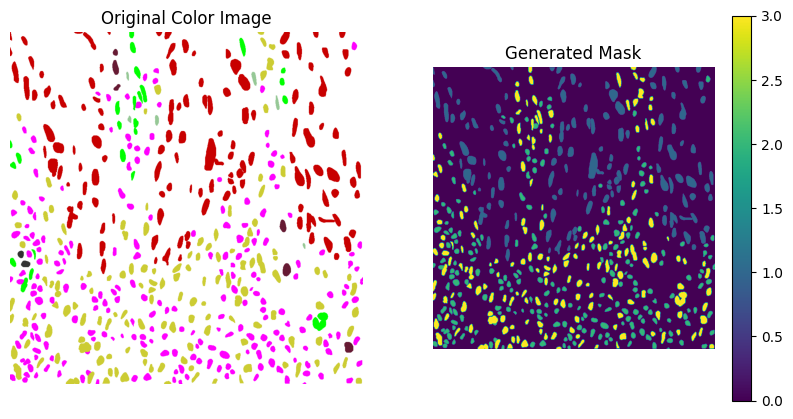

In [18]:
import numpy as np
from PIL import Image

# Definiere die explizite Farbkodierung
color_to_class_map = {
    (255, 255, 255): 0,    # Background
    (200, 0, 0): 1,        # nuclei_tumor
    (255, 0, 255): 2,      # TILs (lymphocytes and plasma cells)
    (150, 200, 150): 3,    # Other cells (histiocytes, stromal cells, etc.)
    (0, 255, 0): 3,
    (51, 0, 51): 3,
    (0, 128, 128): 3,
    (204, 204, 51): 3,
    (102, 26, 51): 3,
    (51, 51, 51): 3
}

def map_colors_to_classes(color_image_path):
    # Lade das Bild
    color_image = Image.open(color_image_path).convert("RGB")
    color_array = np.array(color_image)
    print(color_array.shape)

    # Identifiziere eindeutige Farben im Bild
    unique_colors = np.unique(color_array.reshape(-1, color_array.shape[2]), axis=0)
    print("Alle eindeutigen Farben im Bild:")
    for color in unique_colors:
        print(tuple(color))

    # Erstelle eine leere Maske für die Klassenzuordnung
    mask = np.zeros((color_array.shape[0], color_array.shape[1]), dtype=np.uint8)

    # Mapping der Farben auf Klassen
    print("Gefundene Farben und deren Zuordnungen:")
    for color in unique_colors:
        color_tuple = tuple(color)
        
        # Bestimme die Klasse, entweder durch explizite Zuordnung oder Standardklasse 3
        class_value = color_to_class_map.get(color_tuple, 3)
        
        # Finde alle Pixel, die dieser Farbe entsprechen, und setze die Klasse in der Maske
        is_color = np.all(color_array == color_tuple, axis=-1)
        
        if np.any(is_color):  # Nur wenn die Farbe im Bild vorkommt
            print(f"Farbe: {color_tuple} -> Klasse: {class_value}")
            mask[is_color] = class_value
    
    return mask

# Beispiel zur Nutzung

color_image_path =  r'../dataset/nuclei/training_set_primary_roi_099.png'  # Ersetze dies mit dem Pfad zu deinem Bild
mask = map_colors_to_classes(color_image_path)

color_image = Image.open(color_image_path).convert("RGB")

# Plotten des Originalbildes und der Maske
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Originales Farbbild anzeigen
axes[0].imshow(color_image)
axes[0].set_title("Original Color Image")
axes[0].axis('off')

# Maske anzeigen
im = axes[1].imshow(mask, cmap='viridis')
axes[1].set_title("Generated Mask")
axes[1].axis('off')

# Farblegende für die Maske
plt.colorbar(im, ax=axes[1])

plt.show()




(1024, 1024, 3)
Alle eindeutigen Farben im Bild:
(23, 172, 169)
(150, 200, 150)
(200, 0, 0)
(255, 255, 255)
Gefundene Farben und deren Zuordnungen:
Farbe: (255, 255, 255) -> Klasse: 0
Farbe: (150, 200, 150) -> Klasse: 1
Farbe: (200, 0, 0) -> Klasse: 3
Farbe: (23, 172, 169) -> Klasse: 4


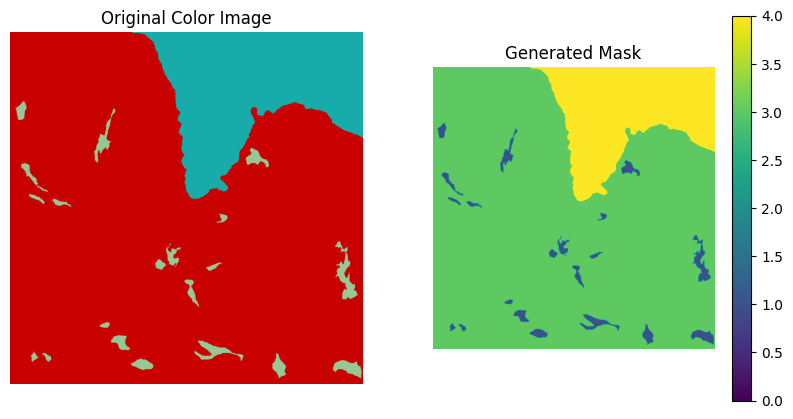

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Funktion zum Umwandeln eines Farbbildes in eine Maske
def color_image_to_mask(color_image):
    
    color_to_class_map = {
        (255, 255, 255): 0,
        (150, 200, 150): 1,
        (0, 255, 0): 2,
        (200, 0, 0): 3,
        (23, 172, 169): 4,
        (51, 0, 51): 5
    }


    color_array = np.array(color_image)
    print(color_array.shape)
    
    unique_colors = np.unique(color_array.reshape(-1, color_array.shape[2]), axis=0)

    print("Alle eindeutigen Farben im Bild:")
    for color in unique_colors:
        print(tuple(color))  # Gib die Farbe als Tupel (R, G, B) aus



    
    mask = np.zeros((color_array.shape[0], color_array.shape[1]), dtype=np.uint8)

    print("Gefundene Farben und deren Zuordnungen:")
    
    for color, class_value in color_to_class_map.items():
        is_color = np.all(color_array == color, axis=-1)
        if np.any(is_color):  # Nur wenn die Farbe im Bild vorkommt
            print(f"Farbe: {color} -> Klasse: {class_value}")
            mask[is_color] = class_value
            
    return mask

# Lade das Bild von deinem lokalen Laufwerk
image_path =  r'../dataset/tissue/training_set_primary_roi_067.png'  # Ersetze dies mit dem Pfad zu deinem Bild
color_image = Image.open(image_path).convert('RGB')

# Wende die Funktion an
mask = color_image_to_mask(color_image)

# Plotten des Originalbildes und der Maske
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Originales Farbbild anzeigen
axes[0].imshow(color_image)
axes[0].set_title("Original Color Image")
axes[0].axis('off')

# Maske anzeigen
im = axes[1].imshow(mask, cmap='viridis')
axes[1].set_title("Generated Mask")
axes[1].axis('off')

# Farblegende für die Maske
plt.colorbar(im, ax=axes[1])

plt.show()




## patches erstellen

In [3]:
# tissue_white_background	0
# tissue_stroma	1
# tissue_blood_vessel	2
# tissue_tumor	3
# tissue_epidermis	4
# tissue_necrosis	5




tissue_class_colors = {
    'tissue_blood_vessel': (0, 255, 0),
    'tissue_tumor': (200, 0, 0),
    'tissue_stroma': (150, 200, 150),
    'tissue_epidermis': (23, 172, 169),
    'tissue_white_background': (255, 255, 255),
    'tissue_necrosis': (51, 0, 51)
}


nuclei_class_colors = {
    'nuclei_tumor': (200, 0, 0),
    'nuclei_lymphocyte': (255, 0, 255),
    'nuclei_stroma': (150, 200, 150),
    'nuclei_neutrophil': (0, 255, 255),
    'nuclei_endothelium': (0, 255, 0),
    'nuclei_melanophage': (89, 165, 113),
    'nuclei_plasma_cell': (3, 193, 98),
    'nuclei_histiocyte': (52, 4, 179),
    'nuclei_apoptosis': (51, 0, 51),
    'nuclei_epithelium': (99, 145, 164)
}




def color_image_to_mask_nuclei(color_image):
    # Define your color mapping
    color_to_class_map = {
        (255, 255, 255): 0,    # weisser Hintergrund
        (200, 0, 0): 1,       # nuclei_tumor
        (255, 0, 255): 2,     # nuclei_lymphocyte
        (150, 200, 150): 3,   # nuclei_stroma
        (0, 255, 255): 4,     # nuclei_neutrophil
        (0, 255, 0): 5,       # nuclei_endothelium
        (89, 165, 113): 6,    # nuclei_melanophage
        (3, 193, 98): 7,      # nuclei_plasma_cell
        (52, 4, 179): 8,      # nuclei_histiocyte
        (51, 0, 51): 9,       # nuclei_apoptosis
        (99, 145, 164): 10    # nuclei_epithelium
    }

    # Initialize the mask
    color_array = np.array(color_image)
    mask = np.zeros((color_array.shape[0], color_array.shape[1]), dtype=np.uint8)

    for color, class_value in color_to_class_map.items():
        is_color = np.all(color_array == color, axis=-1)
        mask[is_color] = class_value

    return mask




def color_image_to_mask(color_image):
    color_to_class_map = {
        (255, 255, 255): 0,
        (150, 200, 150): 1,
        (0, 255, 0): 2,
        (200, 0, 0): 3,
        (23, 172, 169): 4,
        (51, 0, 51):5
        }

    color_array = np.array(color_image)
    mask = np.zeros((color_array.shape[0], color_array.shape[1]), dtype=np.uint8)

    for color, class_value in color_to_class_map.items():
        is_color = np.all(color_array == color, axis=-1)
        mask[is_color] = class_value
    return mask

In [8]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm


def extract_and_save_patches(image, mask, mask_nuclei, patch_size, patch_overlap, save_folder_images, save_folder_masks, slide_name, save_folder_masks_nuclei, include_border_patches=True):
    """
    Extracts patches from a given image, tissue mask, and nuclei mask, and saves them to the specified folders.
    
    Parameters:
    - image: The full slide image as a NumPy array.
    - mask: The corresponding tissue mask for the image.
    - mask_nuclei: The corresponding nuclei mask for the image.
    - patch_size: The size of each patch (height and width).
    - patch_overlap: The overlap between consecutive patches.
    - save_folder_images: The folder where image patches should be saved.
    - save_folder_masks: The folder where tissue mask patches should be saved.
    - slide_name: The name of the slide (used to name the patches).
    - save_folder_masks_nuclei: The folder where nuclei mask patches should be saved.
    - include_border_patches: Whether to include border patches with less than the full patch size.
    """

    img_h, img_w = image.shape[:2]
    mask_h, mask_w = mask.shape[:2]
    mask_nuclei_h, mask_nuclei_w = mask_nuclei.shape[:2]

    assert img_h == mask_h == mask_nuclei_h and img_w == mask_w == mask_nuclei_w, "Image, tissue mask, and nuclei mask dimensions do not match."

    step = patch_size - patch_overlap
    num_patches_y = (img_h - patch_overlap) // step
    num_patches_x = (img_w - patch_overlap) // step

    for y in range(num_patches_y):
        for x in range(num_patches_x):
            x_start = x * step
            y_start = y * step

            x_end = x_start + patch_size
            y_end = y_start + patch_size

            if include_border_patches:
                if x_end > img_w:
                    x_end = img_w
                    x_start = img_w - patch_size
                if y_end > img_h:
                    y_end = img_h
                    y_start = img_h - patch_size

            image_patch = image[y_start:y_end, x_start:x_end]
            mask_patch = mask[y_start:y_end, x_start:x_end]
            mask_nuclei_patch = mask_nuclei[y_start:y_end, x_start:x_end]

            if len(image_patch.shape) == 2:  # If it's grayscale, convert it to RGB
                image_patch = np.stack([image_patch]*3, axis=-1)


            # Save the patches
            image_patch_filename = os.path.join(save_folder_images, f"{slide_name}_img_patch_{x_start}_{y_start}.png")
            mask_patch_filename = os.path.join(save_folder_masks, f"{slide_name}_tissue_patch_{x_start}_{y_start}.png")
            mask_nuclei_patch_filename = os.path.join(save_folder_masks_nuclei, f"{slide_name}_nuclei_patch_{x_start}_{y_start}.png")

            Image.fromarray(image_patch).convert("RGB").save(image_patch_filename)
            Image.fromarray(mask_patch).convert("RGB").save(mask_patch_filename)  # Save mask as RGB (if required, change back to grayscale)
            Image.fromarray(mask_nuclei_patch).convert("RGB").save(mask_nuclei_patch_filename)  # Save nuclei mask as RGB (if required, change back to grayscale)
    
            # Image.fromarray(image_patch).save(image_patch_filename)
            # Image.fromarray(mask_patch).save(mask_patch_filename)
            # Image.fromarray(mask_nuclei_patch).save(mask_nuclei_patch_filename)



def process_folder(image_folder, mask_folder, mask_folder_nuclei, patch_size, patch_overlap, save_folder_images, save_folder_masks, save_folder_masks_nuclei):
    """
    Iterates over all images and corresponding masks in the specified folders, extracts patches, and saves them.
    """
    # Get all image and mask files from the folder
    mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.tif'))])

    # Ensure save folders exist
    os.makedirs(save_folder_images, exist_ok=True)
    os.makedirs(save_folder_masks, exist_ok=True)

    for mask_file in tqdm((mask_files), total=len(mask_files), desc="Processing files"):
        
        slide_name = os.path.splitext(mask_file)[0]
        slide_name = os.path.splitext(slide_name)[0]


        image_path = os.path.join(image_folder, str(slide_name+".tif"))
        mask_path = os.path.join(mask_folder, mask_file)

        mask_path_nuclei = os.path.join(mask_folder_nuclei, str(slide_name+".png"))

        # Load the image and mask
        image = np.array(Image.open(image_path))

        # Load and convert mask images to RGB
        mask = np.array(Image.open(mask_path).convert('RGB'))
        mask_nuclei = np.array(Image.open(mask_path_nuclei).convert('RGB'))

        # mask = np.array(Image.open(mask_path))
        # mask_nuclei = np.array(Image.open(mask_path_nuclei))
        
        # mask = color_image_to_mask(Image.open(mask_path))
        # mask_nuclei = color_image_to_mask_nuclei(np.array(Image.open(mask_path_nuclei)))

        # Generate the slide name based on the image file name (without extension)

        # Extract patches and save them
        extract_and_save_patches(image, mask, mask_nuclei, patch_size, patch_overlap, save_folder_images, save_folder_masks, slide_name, save_folder_masks_nuclei)



image_folder = r'../dataset/01_training_dataset_tif_ROIs'
mask_folder = r'../dataset/tissue'
mask_folder_nuclei = r'../dataset/nuclei'

save_folder_images = r'../dataset/patches/images'
save_folder_masks = r'../dataset/patches/tissue_mask'
save_folder_masks_nuclei = r'../dataset/patches/nuclei_mask'


patch_size = 256
patch_overlap = 64


process_folder(image_folder, mask_folder, mask_folder_nuclei, patch_size, patch_overlap, save_folder_images, save_folder_masks, save_folder_masks_nuclei)




Processing files: 100%|███████████████████████████████████████████████████| 206/206 [03:37<00:00,  1.05s/it]


## get patch Infos

In [3]:
import os
import pandas as pd
from tqdm import tqdm

def load_multi_patch_info_df(folder_path, patch_type):
    """
    Loads patch information from a folder, including filenames, slide names, paths, class, and patch coordinates.
    
    Parameters:
    - folder_path: The path to the folder containing the patches.
    - slide_class: The class (e.g., 'primary') associated with the patches.
    - patch_type: The type of patch, either 'img', 'tissue', or 'nuclei'.

    Returns:
    - A DataFrame containing filenames, slide names, paths, class, and patch coordinates (x, y).
    """
    
    data = []
    
    # Iterate over all files in the folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.tif')):  # Only process image files
                file_path = os.path.join(root, file)
                
                # Extract the slide name by removing the part after '_roi_XXX'
                # Example: "training_set_primary_roi_039_img_patch_192_192.png" -> "training_set_primary_roi_039"
                slide_name_parts = file.split("_")
                slide_name = "_".join(slide_name_parts[:5]) 


                if 'primary' in slide_name:
                    slide_class = 'primary'
                elif 'metastatic' in slide_name:
                    slide_class = 'metastatic'
                else:
                    slide_class = 'unknown' 
                
                # Extract x, y coordinates from the filename (assuming format: "training_set_primary_roi_XXX_patch_x_y.png")
                try:
                    x_coord = int(slide_name_parts[-2])  # Extract second to last part as x-coordinate
                    y_coord = int(slide_name_parts[-1].split(".")[0])  # Extract last part (without extension) as y-coordinate
                except:
                    x_coord, y_coord = None, None  # In case of an unexpected filename format

                data.append({
                    "filename": file,             # Patch file name
                    "slide_name": slide_name,     # Slide name extracted from the file
                    "path": file_path,            # Full path to the file
                    "class": slide_class,         # Class associated with this slide (e.g., 'primary')
                    "x_coord": x_coord,           # X-coordinate of the patch
                    "y_coord": y_coord            # Y-coordinate of the patch
                })
    
    df = pd.DataFrame(data)
    
    # Check if the dataframe is empty for debugging purposes
    if df.empty:
        print(f"No files processed in folder: {folder_path}")
    else:
        print(f"Processed {len(df)} files from folder: {folder_path}")
    
    return df

df_image = load_multi_patch_info_df(
    r"../dataset/patches/images", "img_patch"
)
df_mask = load_multi_patch_info_df(
    r'../dataset/patches/tissue_mask', "tissue_patch"
)
df_nuclei_mask = load_multi_patch_info_df(
    r'../dataset/patches/nuclei_mask', "nuclei_patch"
)




df_mask.rename(columns={"path": "tissue_mask"}, inplace=True)

# Zusammenführen basierend auf 'slide_name'

df_nuclei_mask.rename(columns={"path": "nuclei_mask"}, inplace=True)


df_image = df_image.merge(df_mask[["slide_name", "x_coord", "y_coord", "tissue_mask"]], how="inner", on=["slide_name", "x_coord", "y_coord"])
df_image = df_image.merge(df_nuclei_mask[["slide_name", "x_coord", "y_coord", "nuclei_mask"]], how="inner", on=["slide_name", "x_coord", "y_coord"])




print(len(df_image))
df_image.head()



df_image.to_csv("dataset/patch_info.csv", sep=";" ,index=False)

Processed 5150 files from folder: ../dataset/patches/images
Processed 5152 files from folder: ../dataset/patches/tissue_mask
Processed 5151 files from folder: ../dataset/patches/nuclei_mask
5150


In [2]:
df_image

NameError: name 'df_image' is not defined

# classes

In [2]:
#df = df_image.copy()
df = pd.read_csv("dataset/patches_classes.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/patches_classes.csv'

In [64]:
import numpy as np
from PIL import Image

# Definiere die explizite Farbkodierung
color_to_class_map = {
    (255, 255, 255): 0,    # Background
    (200, 0, 0): 1,        # nuclei_tumor
    (255, 0, 255): 2,      # TILs (lymphocytes and plasma cells)
    (150, 200, 150): 3,    # Other cells (histiocytes, stromal cells, etc.)
    (0, 255, 0): 3,
    (51, 0, 51): 3,
    (0, 128, 128): 3,
    (204, 204, 51): 3,
    (102, 26, 51): 3,
    (51, 51, 51): 3
}

def map_colors_to_classes(color_image_path):
    # Lade das Bild
    color_image = Image.open(color_image_path).convert("RGB")
    color_array = np.array(color_image)

    # Identifiziere eindeutige Farben im Bild
    unique_colors = np.unique(color_array.reshape(-1, color_array.shape[2]), axis=0)


    # Erstelle eine leere Maske für die Klassenzuordnung
    mask = np.zeros((color_array.shape[0], color_array.shape[1]), dtype=np.uint8)

    # Mapping der Farben auf Klassen
    for color in unique_colors:
        color_tuple = tuple(color)
        # Bestimme die Klasse, entweder durch explizite Zuordnung oder Standardklasse 3
        class_value = color_to_class_map.get(color_tuple, 3)
        # Finde alle Pixel, die dieser Farbe entsprechen, und setze die Klasse in der Maske
        is_color = np.all(color_array == color_tuple, axis=-1)
        if np.any(is_color):  # Nur wenn die Farbe im Bild vorkommt
            mask[is_color] = class_value
    
    return mask

In [65]:
masks_classes = []
masks_class_percentages = []

for idx in tqdm(df.index):
    img_row = df.iloc[idx]
    mask_path = img_row["nuclei_mask"]
    mask = Image.open(mask_path).convert("L")
    mask = np.array(mask)
    mask = map_colors_to_classes(mask_path)
    # mask_nuclei = color_image_to_mask_nuclei(np.array(Image.open(mask_path_nuclei)))

    mask = torch.from_numpy(mask)
    mask = np.eye(4)[mask]
    class_occurrences_per_pixel = mask.sum(axis=-1)
    class_occurrences_per_pixel[class_occurrences_per_pixel == 0] = 1
    adjusted_mask = mask / class_occurrences_per_pixel[..., np.newaxis]
    class_sums = adjusted_mask.sum(axis=(0, 1))
    total_pixels = mask.shape[0] * mask.shape[1]
    class_percentages = (class_sums / total_pixels) * 100
    unique_classes = np.where(class_sums[1:] > 0)[0] + 1
    masks_classes.append(unique_classes)
    class_percentages = class_percentages[1:]
    masks_class_percentages.append(class_percentages[class_percentages > 0].round(1))

df["unique_mask_indices"] = masks_classes
df["class_prc"] = masks_class_percentages

100%|███████████████████████████████████████| 5150/5150 [05:44<00:00, 14.94it/s]


In [66]:
df.to_csv("dataset/new_patches_classes.csv", index=False)

In [67]:
df = pd.read_csv("dataset/new_patches_classes.csv")
df.head()

,filename,slide_name,path,class,x_coord,y_coord,tissue_mask,nuclei_mask,unique_mask_indices,class_prc
0,training_set_metastatic_roi_072_img_patch_768_...,training_set_metastatic_roi_072,../dataset/patches/images/training_set_metasta...,metastatic,768,192,../dataset/patches/tissue_mask/training_set_me...,../dataset/patches/nuclei_mask/training_set_me...,[1 2],[24.3 2.6]
1,training_set_metastatic_roi_009_img_patch_0_76...,training_set_metastatic_roi_009,../dataset/patches/images/training_set_metasta...,metastatic,0,768,../dataset/patches/tissue_mask/training_set_me...,../dataset/patches/nuclei_mask/training_set_me...,[1],[25.]
2,training_set_metastatic_roi_090_img_patch_768_...,training_set_metastatic_roi_090,../dataset/patches/images/training_set_metasta...,metastatic,768,576,../dataset/patches/tissue_mask/training_set_me...,../dataset/patches/nuclei_mask/training_set_me...,[1 2 3],[11. 0.3 0.7]
3,training_set_primary_roi_078_img_patch_384_0.png,training_set_primary_roi_078,../dataset/patches/images/training_set_primary...,primary,384,0,../dataset/patches/tissue_mask/training_set_pr...,../dataset/patches/nuclei_mask/training_set_pr...,[1],[14.7]
4,training_set_primary_roi_092_img_patch_768_0.png,training_set_primary_roi_092,../dataset/patches/images/training_set_primary...,primary,768,0,../dataset/patches/tissue_mask/training_set_pr...,../dataset/patches/nuclei_mask/training_set_pr...,[1],[20.]


In [68]:
len(df)

5150

# train val split

In [69]:
df["unique_mask_indices"] = (
    df["unique_mask_indices"]
    .str[1:-1]
    .str.split(" ")
    .map(lambda x: [int(i) for i in x if i != ""])  # Füge eine Überprüfung hinzu
)


df["class_prc"] = (
    df["class_prc"]
    .str[1:-1]
    .str.split(" ")
    .map(lambda x: [float(i) for i in x if i != ""])
)

In [70]:
len(df)

5150

In [71]:
rare_classes = [10]

df["class"] = df.apply(
    lambda x: next((cls for cls in x["unique_mask_indices"] if cls in rare_classes), 
                   x["unique_mask_indices"][np.array(x["class_prc"]).argmax()]) 
    if len(x["class_prc"]) > 0 else 0, axis=1
)

In [72]:
df["class"]

0       1
1       1
2       1
3       1
4       1
       ..
5145    1
5146    1
5147    1
5148    2
5149    1
Name: class, Length: 5150, dtype: int64

In [79]:
contains_class_3 = df[df["class"].apply(lambda x: 10 == x)]
print(len(contains_class_3))

0


In [80]:
from sklearn.model_selection import train_test_split

unique_slide_names = df["slide_name"].unique()

train_slide_names, valid_slide_names = train_test_split(
    unique_slide_names, test_size=0.2, random_state=42
)

train_df = df[df["slide_name"].isin(train_slide_names)]
valid_df = df[df["slide_name"].isin(valid_slide_names)]


train_df.to_csv("dataset/new_train.csv", index=False)
valid_df.to_csv("dataset/new_val.csv", index=False)

In [82]:
import pandas as pd

# Load train and validation dataframes
train_df = pd.read_csv("dataset/new_train.csv")
valid_df = pd.read_csv("dataset/new_val.csv")

# Get the unique slide names in both train and validation sets
train_slide_names = set(train_df["slide_name"])
valid_slide_names = set(valid_df["slide_name"])

# Find the intersection of slide names
common_slide_names = train_slide_names.intersection(valid_slide_names)

# Print the number of unique slides in train, valid, and their intersection
print(f"Number of unique slides in train: {len(train_slide_names)}")
print(f"Number of unique slides in valid: {len(valid_slide_names)}")
print(f"Number of common slides: {len(common_slide_names)}")

# Check if the intersection is empty
if not common_slide_names:
    print("The intersection is empty, as expected.")
else:
    print(f"Common slide names: {common_slide_names}")

Number of unique slides in train: 164
Number of unique slides in valid: 42
Number of common slides: 0
The intersection is empty, as expected.


In [83]:
# Calculating class distribution in the training dataset
train_class_distribution = train_df["class"].value_counts(normalize=True)*100

# Calculating class distribution in the validation dataset
valid_class_distribution = valid_df["class"].value_counts(normalize=True)*100

# Printing the class distributions
print("Class distribution in the training dataset:")
print(train_class_distribution)

print("\nClass distribution in the validation dataset:")
print(valid_class_distribution)

Class distribution in the training dataset:
1    73.926829
3    17.463415
2     8.536585
0     0.073171
Name: class, dtype: float64

Class distribution in the validation dataset:
1    81.809524
3    12.857143
2     5.333333
Name: class, dtype: float64


In [40]:
import pandas as pd

train_df = pd.read_csv("dataset/train.csv")
class_weights = (1 / train_df["class"].value_counts(normalize=True)) * 100

train_df["weight"] = train_df["class"].map(class_weights)

train_df.to_csv("dataset/train.csv", index=False)

In [42]:
np.unique(class_weights)

array([   142.50955857,    337.44855967,  82000.        , 136666.66666667])

In [44]:
weights = torch.DoubleTensor(train_df['weight'].values)
max_weight = weights.max()
min_weight = weights.min()
scaled_weights = (weights - min_weight) / (max_weight - min_weight)
adjusted_weights = torch.pow(scaled_weights, 0.5)

In [45]:
unique_adjusted_weights = torch.unique(scaled_weights)
print(unique_adjusted_weights)

tensor([0.0000, 0.0014, 0.5996, 1.0000], dtype=torch.float64)


In [17]:
import pandas as pd
import ast

def filter_exclude_value(df, column_name="unique_mask_indices", exclude_value=1, save_path="filtered_data.csv"):
    """
    Filters the DataFrame to exclude rows where the specified value exists in the list.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column containing string representations of lists.
        exclude_value (int): The value to exclude.
        save_path (str): The path to save the filtered DataFrame as a CSV file.

    Returns:
        pd.DataFrame: The filtered DataFrame.
    """
    # Ensure the column exists
    if column_name not in df.columns:
        raise ValueError(f"The column '{column_name}' does not exist in the DataFrame.")
    
    # Define a function to process each value
    def does_not_contain_exclude_value(value):
        try:
            # Convert string to list
            value_list = ast.literal_eval(value) if isinstance(value, str) else value
            # Exclude rows where the list contains the exclude_value
            return exclude_value not in value_list
        except (ValueError, SyntaxError):
            # If conversion fails, exclude the row
            return False

    # Apply the filtering
    filtered_df = df[df[column_name].apply(does_not_contain_exclude_value)]
    
    # Save the filtered DataFrame to a CSV file
    filtered_df.to_csv(save_path, index=False)
    
    return filtered_df

output_dir=r"../augmented_data"
path = os.path.join(output_dir, "augmented_patch_info.csv")
output_path = os.path.join(output_dir, "filtered_augmented_patch_info.csv")

df = pd.read_csv(path)

# Filter aufrufen und speichern
filtered_df = filter_exclude_value(df, save_path=output_path)
print(len(df))
print(len(filtered_df))

8200
4042
